In [1]:
# ----------------------------------------
# Step 1: Setup and Imports
# ----------------------------------------

# 🔹 system and utility libraries
import os                            # Provides tools for working with file paths, directories, and filesystem operations
import random                        # Used for generating random numbers (e.g., random seeds, data shuffling)
import numpy as np                   # Fundamental package for numerical computations and array manipulation
from tqdm import tqdm                # progress bar utility for visualizing training or evaluation loops
from pathlib import Path             # Import the Path class for handling dataset directories and file paths
import shutil                        # provides high-level operations on files and directories
from collections import OrderedDict  # Dictionary that preserves the order of inserted items — useful for organizing dataset statistics

# 🔹 Evaluation and performance metrics
from sklearn.metrics import (
    classification_report,          # Generates a detailed report with precision, recall, and F1-score per class
    confusion_matrix,               # Computes the confusion matrix for classification tasks
    ConfusionMatrixDisplay,         # Enables easy visualization of confusion matrices
    accuracy_score,                 # Calculates overall accuracy
    precision_score,                # Calculates precision (positive predictive value)
    recall_score,                   # Calculates recall (sensitivity)
    f1_score                        # Calculates the harmonic mean of precision and recall
)

# 🔹 Image processing and visualization libraries
import cv2                         # OpenCV — used for image reading, preprocessing, and augmentations
import matplotlib.pyplot as plt    # For plotting training metrics, sample predictions, and visualizations

# 🔹 PyTorch core and utilities
import torch                       # The main PyTorch library for tensors and GPU acceleration
import torch.nn as nn              # Provides neural network components (layers, loss functions, activations)
import torch.optim as optim        # Optimization algorithms like Adam, SGD, etc.
import timm                        # PyTorch Image Models library — includes modern architectures like ViT, EfficientNet, ConvNeXt, etc.
from torch.utils.data import DataLoader, random_split  # Utilities for batching and splitting datasets

# 🔹 Torchvision: pretrained models, datasets, and transformations
import torchvision                # The main library for computer vision tasks built on PyTorch
from torchvision import datasets, models, transforms    # Provides ready-to-use datasets and pretrained CNN models
import torchvision.transforms.functional as F           # Contains lower-level image transformation functions (e.g., flip, rotate, crop)

In [2]:
# --------------------------------------------------------
# Step 2: Set computation device: GPU if available, otherwise CPU
# -------------------------------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {device}")


Using device: cuda


In [3]:
# ----------------------------------------
# Step 3: Mount Google Drive
# ----------------------------------------
from google.colab import drive

# Mount your Google Drive so Colab can access files stored there
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [4]:
# ---------------------------------------------------------------------------------------------------------------
# Step 4: Download the data from https://www.kaggle.com/datasets/sovitrath/diabetic-retinopathy-224x224-2019-data
# ---------------------------------------------------------------------------------------------------------------

!unzip -q "/content/gdrive/MyDrive/data/archive1.zip" -d /content/


In [5]:
# ------------------------------------------------------------------
# Step 5: Describe number of classes and samples of each data class
# ------------------------------------------------------------------
# define a path
data_dir = Path("/content/colored_images")

# Initialize result dict
class_counts = OrderedDict()

# Loop through subfolders (each class)
for class_dir in sorted(data_dir.iterdir()):
    if class_dir.is_dir():
        # Count all .png images in this subfolder
        count = len(list(class_dir.glob("*.png")))
        class_counts[class_dir.name] = count
# Print results
width = max(len(name) for name in class_counts.keys()) if class_counts else 10
print(f"{'Class'.ljust(width)} | Count")
print("-" * (width + 8))
for cls_name, cnt in class_counts.items():
    print(f"{cls_name.ljust(width)} | {cnt}")
print("-" * (width + 8))
print(f"Total images: {sum(class_counts.values())}")
print(f"Num classes : {len(class_counts)}")
num_classes = len(class_counts)

# Optional: get lists/dicts if needed later
class_names = list(class_counts.keys())
counts_dict = dict(class_counts)

Class          | Count
----------------------
Mild           | 370
Moderate       | 999
No_DR          | 1805
Proliferate_DR | 295
Severe         | 193
----------------------
Total images: 3662
Num classes : 5


In [6]:
# ------------------------------------------------------------------
# Step 6: Split the dataset into training, validation, and testing sets
# ------------------------------------------------------------------

# Define input and output directories
data_dir = 'colored_images'     # Root folder containing one subfolder per class (e.g., cats/, dogs/)
output_dir = 'dataset_split'    # Destination folder where train/val/test folders will be created

# Create the output directory if it doesn’t already exist
os.makedirs(output_dir, exist_ok=True)

# Define split ratios for training, validation, and testing sets
train_ratio = 0.7           
val_ratio = 0.15  
test_ratio = 0.15   

# Set a fixed random seed to ensure reproducibility (same shuffle order every time)
random.seed(42)

# Loop through each class folder 
for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    
    # Skip non-directory files (only process folders)
    if not os.path.isdir(class_dir):
        continue

    # Get all image filenames in the class directory (supports .png, .jpg, .jpeg)
    images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # Randomly shuffle the image list to avoid order bias
    random.shuffle(images)

    # Compute the number of samples for each split
    n_total = len(images)
    n_train = int(train_ratio * n_total)
    n_val = int(val_ratio * n_total)

    # Slice the image list into training, validation, and test subsets
    train_files = images[:n_train]
    val_files = images[n_train:n_train + n_val]
    test_files = images[n_train + n_val:]

    # Copy files to the respective split directory
    def copy_files(file_list, split_name):
        # Construct the output directory path for this class and split
        split_class_dir = os.path.join(output_dir, split_name, class_name)
        os.makedirs(split_class_dir, exist_ok=True)  # Create folder if missing

        # Copy each image file from the source to the new split folder
        for f in file_list:
            shutil.copy(os.path.join(class_dir, f), os.path.join(split_class_dir, f))

    # Copy the split files to train/val/test directories
    copy_files(train_files, 'train')
    copy_files(val_files, 'val')
    copy_files(test_files, 'test')

# Copy the folder to your Drive
!cp -r /content/dataset_split/. /content/drive/MyDrive/retinopathy/

cp: cannot create directory '/content/drive/MyDrive/retinopathy/': No such file or directory


In [7]:
# ---------------------------------------------------------
# Step 7: Load dataset and preprocess transforms
# ---------------------------------------------------------
# Set paths to your image datasets
train_dir = '/content/dataset_split/train'  # Training images directory
val_dir = '/content/dataset_split/val'      # Validation images directory
test_dir = '/content/dataset_split/test'    # Test images directory

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load image datasets using torchvision's ImageFolder structure
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# Dataloaders (shuffled for train/val, not for test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [8]:
# -----------------------------
# Step 9: Define loss function
# -----------------------------
# Define loss function (cross-entropy for classification)
criterion = nn.CrossEntropyLoss()

In [9]:
# --------------------------------------------
# Step 10:Training function for one epoch
# --------------------------------------------
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()                                 # Set model to training mode
    running_loss = 0                              # Track cumulative loss
    progress_bar = tqdm(loader, desc="Training")  # Show progress bar

    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to device

        optimizer.zero_grad()                     # Clear previous gradients
        outputs = model(inputs)                   # Forward pass
        loss = criterion(outputs, labels)         # Compute loss
        loss.backward()                           # Backpropagation
        optimizer.step()                          # Update weights

        running_loss += loss.item()               # Add current batch loss
        progress_bar.set_postfix({'loss': running_loss / (progress_bar.n + 1)})  # Update progress bar

    return running_loss / len(loader)             # Return average loss for the epoch


In [10]:
# -----------------------------------------------------
# Step 11: Evaluation function for validation/testing
# ------------------------------------------------------
# Evaluation function for validation/testing
def evaluate(model, loader, criterion, device):
    model.eval()                                      # Set model to evaluation mode
    running_loss = 0
    correct = 0
    total = 0
    y_true = []
    y_pred = []

    with torch.no_grad():                              # Disable gradient computation
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            _, preds = torch.max(outputs, 1)           # Get predicted class (highest probability)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            correct += (preds == labels).sum().item()  # Count correct predictions
            total += labels.size(0)                    # Total samples


    accuracy = 100 * correct / total                   # Compute accuracy %
    return running_loss / len(loader), accuracy, y_true, y_pred


In [8]:
# ---------------------------------------------------------
# Step 8: Select one of models
# ---------------------------------------------------------

In [54]:
# -----------------------
# Model: ResNet-50
# -----------------------
model_name = 'resnet50'                        # Model architecture name
model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)   # Create the model using the timm library

# Replace the classifier (final fully connected layer)
in_features = model.fc.in_features             # Get the number of input features to the fully connected (fc) layer
model.fc = nn.Sequential(
    #nn.Dropout(p=0.2),                        # Uncomment to reduce overfitting by randomly dropping neurons
    nn.Linear(in_features, num_classes)        # New output layer for our custom number of classes
)
model = model.to(device)                       # Move the model to the computation device (GPU if available, else CPU)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=2e-5)   # Small learning rate value since we’re fine-tuning a pretrained model)

In [56]:
# -----------------------------------------------------
# Step 11: Train the model
# ------------------------------------------------------

EPOCHS = 5  # Number of training epochs (can be increased)

for epoch in range(EPOCHS):
    print(f"\n--- Epoch {epoch+1}/{EPOCHS} ---")                                                # Epoch header
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)             # Train for one epoch
    val_loss, val_accuracy,y_true, y_pred = evaluate(model, val_loader, criterion, device)      # Validate

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.2f}%")


--- Epoch 1/7 ---


Training: 100%|██████████| 81/81 [00:08<00:00,  9.52it/s, loss=0.803]


Train Loss: 0.8030 | Val Loss: 0.7512 | Val Accuracy: 70.88%

--- Epoch 2/7 ---


Training: 100%|██████████| 81/81 [00:08<00:00,  9.66it/s, loss=0.787]


Train Loss: 0.7875 | Val Loss: 0.8677 | Val Accuracy: 70.88%

--- Epoch 3/7 ---


Training: 100%|██████████| 81/81 [00:08<00:00,  9.53it/s, loss=0.783]


Train Loss: 0.7828 | Val Loss: 0.7211 | Val Accuracy: 71.25%

--- Epoch 4/7 ---


Training: 100%|██████████| 81/81 [00:08<00:00,  9.47it/s, loss=0.747]


Train Loss: 0.7472 | Val Loss: 0.7763 | Val Accuracy: 71.25%

--- Epoch 5/7 ---


Training: 100%|██████████| 81/81 [00:08<00:00,  9.62it/s, loss=0.725]


Train Loss: 0.7255 | Val Loss: 0.7076 | Val Accuracy: 73.08%

--- Epoch 6/7 ---


Training: 100%|██████████| 81/81 [00:08<00:00,  9.52it/s, loss=0.718]


Train Loss: 0.7176 | Val Loss: 0.7697 | Val Accuracy: 73.44%

--- Epoch 7/7 ---


Training: 100%|██████████| 81/81 [00:08<00:00,  9.67it/s, loss=0.7]


Train Loss: 0.7002 | Val Loss: 0.6934 | Val Accuracy: 73.08%


In [62]:
# -----------------------
# Step 12: Test evaluation
# -----------------------

#y_true = torch.tensor(y_true)
#y_pred = torch.tensor(y_pred)
test_loss, test_accuracy,y_true, y_pred = evaluate(model, test_loader, criterion, device)
print(f"\nTest Accuracy: {test_accuracy:.2f}\n")  # Display test accuracy

# --- Classification Report ---
print(f'Classification Report of \033[1m{model_name}\033[0m \n')
print(classification_report(y_true, y_pred, target_names=class_names))

# --- Metrics: Precision, Recall, F1, AUC ---
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print matrics
print(f"\nPrecision (weighted): {precision:.4f}")
print(f"\nRecall (weighted): {recall:.4f}")
print(f"\nf1_score (weighted): {f1:.4f}\n")


Test Accuracy: 75.27

Classification Report of resnet50 

                precision    recall  f1-score   support

          Mild       0.00      0.00      0.00        56
      Moderate       0.55      0.98      0.70       151
         No_DR       0.95      0.99      0.97       272
Proliferate_DR       0.00      0.00      0.00        45
        Severe       0.00      0.00      0.00        30

      accuracy                           0.75       554
     macro avg       0.30      0.39      0.33       554
  weighted avg       0.61      0.75      0.67       554


Precision (weighted): 0.6144

Recall (weighted): 0.7527

f1_score (weighted): 0.6667



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

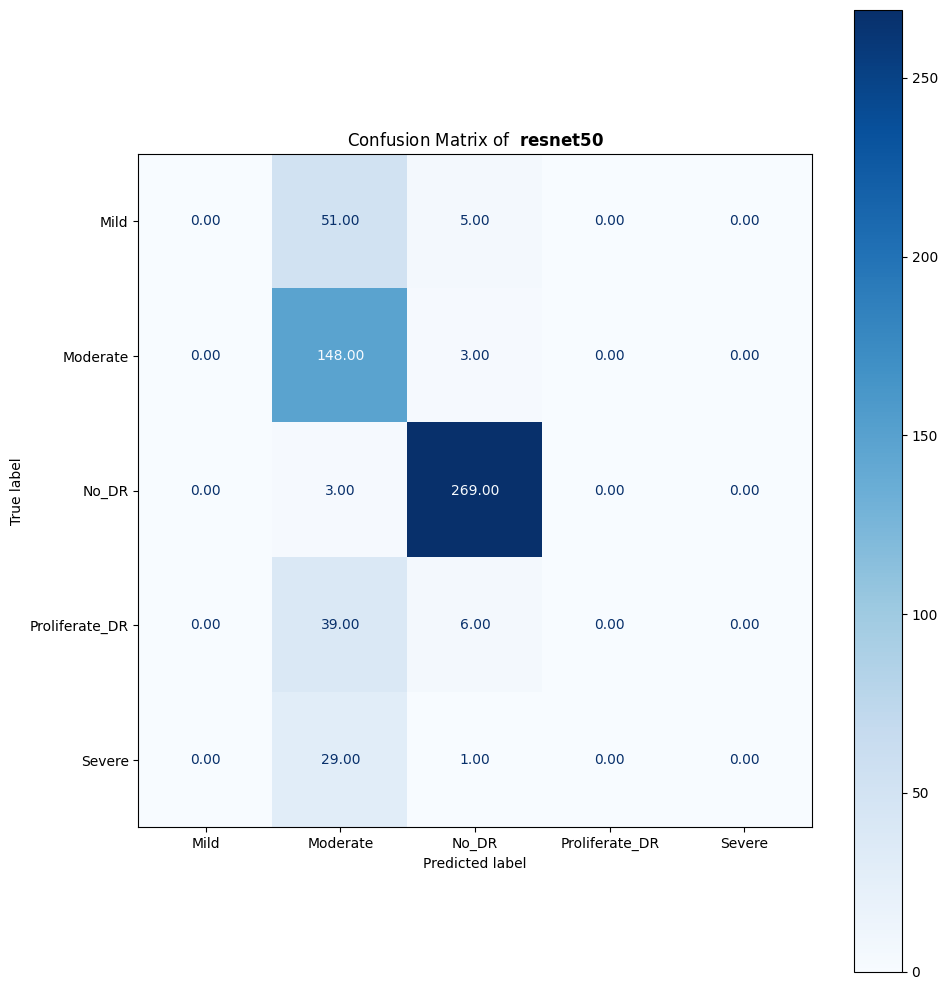

In [58]:
# ----------------------------------------
# Confusion Matrix Visualization
# ----------------------------------------
# - y_true: list or array of true class labels
# - y_pred: list or array of predicted class labels from the model
# - labels: optional list of label names to control matrix ordering
# - normalize: can be set to 'true', 'pred', or 'all' to show relative frequencies instead of raw counts
cm = confusion_matrix(y_true, y_pred, labels=None, normalize=None)


# Initialize a ConfusionMatrixDisplay object to handle plotting
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=class_names if 'class_names' in locals() else None
)

# Create a Matplotlib figure and axis with a defined size
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the confusion matrix
# ---------------------------------------------------
# - cmap='Blues' → blue color gradient for better readability
# - ax=ax → plots on the previously created axis
# - colorbar=True → displays a color scale legend
# - values_format='.2f' → formats cell values with two decimal points (useful if normalized)
disp.plot(cmap='Blues', ax=ax, colorbar=True, values_format='.2f')

# Set a title for the plot, dynamically embedding the model name in bold math text
ax.set_title('Confusion Matrix of  ' + (rf'$\bf{{{model_name}}}$'))

# Adjust layout to prevent overlapping of labels and elements
plt.tight_layout()

# Display the confusion matrix
plt.show()

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


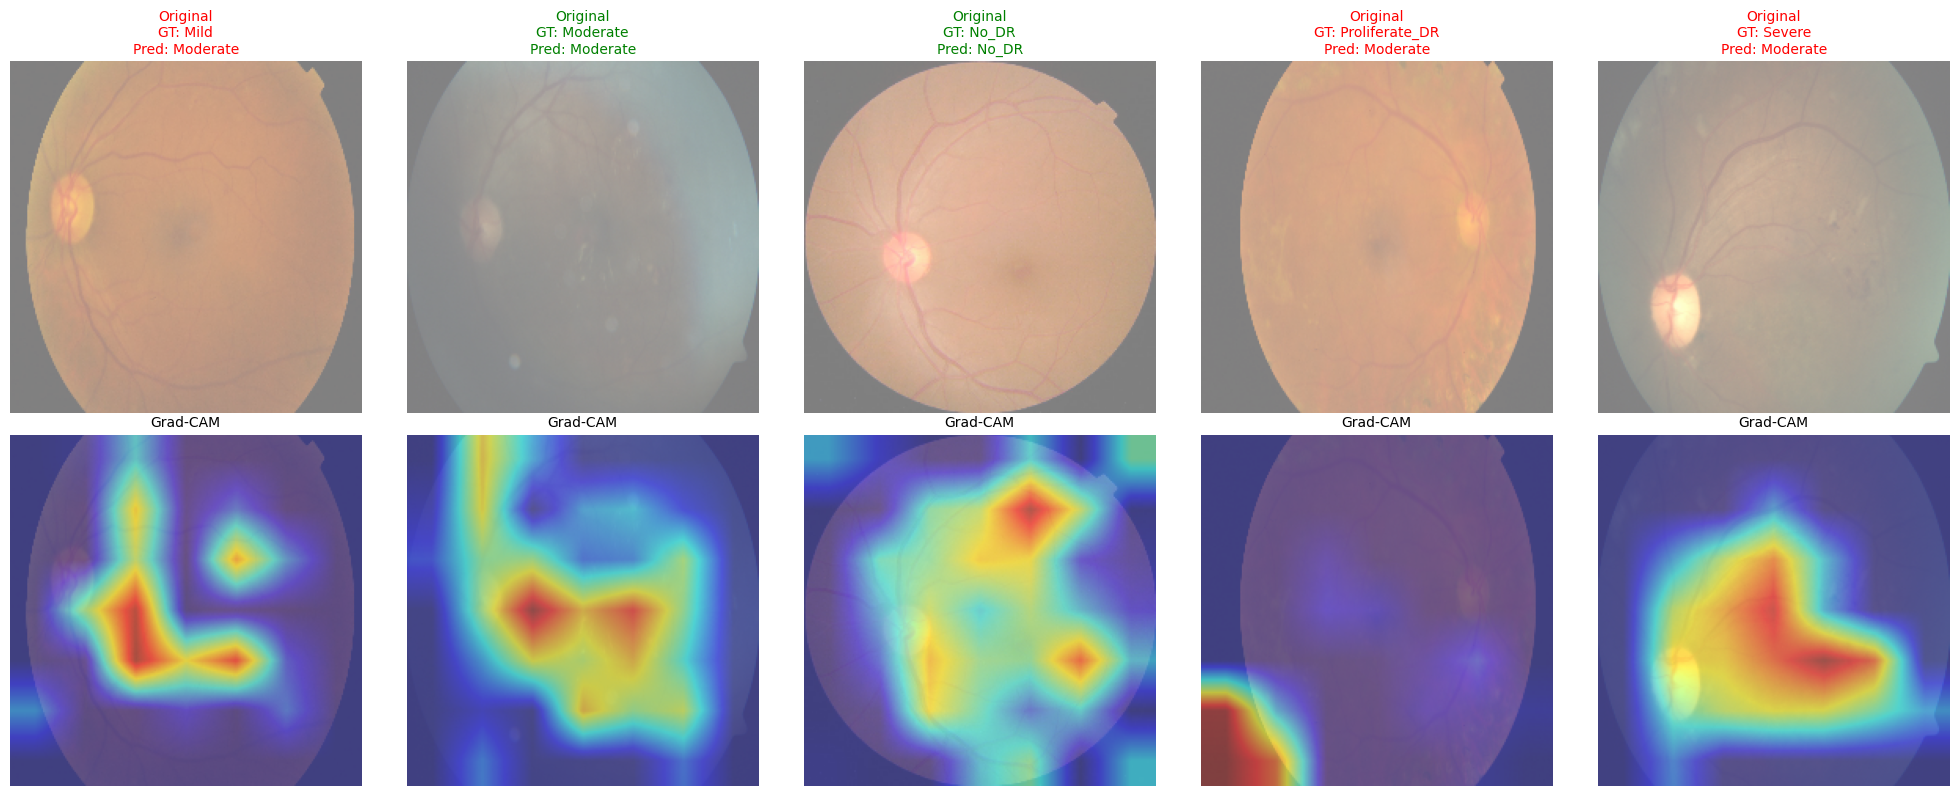

In [59]:
# Import required libraries
import torchvision.transforms.functional as F  # For tensor image transformations
import cv2  # For image processing and heatmap generation

# Generate Grad-CAM heatmap for a specific class prediction
def generate_gradcam(model, input_tensor, target_class=None):
    # Lists to store intermediate feature maps and gradients
    features = []
    gradients = []

    # Hook function to capture feature map output
    def forward_hook(module, input, output):
        features.append(output)

    # Hook function to capture gradients during backward pass
    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    # Register hooks on the last convolutional layer of ResNet
    target_layer = model.layer4[2].conv3  # Typically the last residual block
    handle_forward = target_layer.register_forward_hook(forward_hook)
    handle_backward = target_layer.register_backward_hook(backward_hook)

    # Forward pass
    model.zero_grad()  # Zero out previous gradients
    output = model(input_tensor.unsqueeze(0))  # Add batch dimension

    # If no target class is specified, use the predicted class
    if target_class is None:
        target_class = output.argmax().item()

    # Backward pass for the target class
    loss = output[0, target_class]
    loss.backward()

    # Get gradients and features
    grads = gradients[0]  # Gradients: [B, C, H, W]
    fmap = features[0]    # Feature map: [B, C, H, W]

    # Compute weights via global average pooling on gradients
    weights = grads.mean(dim=(2, 3), keepdim=True)

    # Weighted sum of feature maps
    cam = (weights * fmap).sum(dim=1).squeeze()

    # Apply ReLU and normalize the heatmap
    cam = torch.relu(cam)
    cam = cam - cam.min()
    cam = cam / cam.max()

    # Convert to numpy array
    cam = cam.cpu().detach().numpy()

    # Remove hooks after use
    handle_forward.remove()
    handle_backward.remove()

    return cam

# Visualize predictions with and without Grad-CAM
def show_predictions_with_and_without_gradcam(model, loader, device, class_names):
    model.eval()  # Set model to evaluation mode

    # Dictionary to store one example per class
    collected = {classname: None for classname in class_names}

    # Loop to collect one correctly or incorrectly predicted image per class
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                true_label_idx = labels[i].cpu().item()
                true_label_name = class_names[true_label_idx]

                # Store the first example found for each class
                if collected[true_label_name] is None:
                    collected[true_label_name] = (inputs[i].cpu(), preds[i].cpu())

            # Stop once we have one image per class
            if all(v is not None for v in collected.values()):
                break

    # Create a figure with space for original and Grad-CAM images
    num_classes = len(class_names)
    fig = plt.figure(figsize=(num_classes * 4, 8))

    for idx, classname in enumerate(class_names):
        img, pred = collected[classname]
        cam = generate_gradcam(model, img.to(device), target_class=pred.item())  # Generate Grad-CAM

        # Prepare original image for display
        img_plot = img.permute(1, 2, 0).numpy()  # Change from CxHxW to HxWxC
        img_plot = (img_plot * 0.5) + 0.5  # Denormalize (from mean=0.5, std=0.5)
        img_plot = np.clip(img_plot, 0, 1)  # Clip values between 0 and 1

        # Resize and colorize CAM heatmap
        cam = cv2.resize(cam, (img_plot.shape[1], img_plot.shape[0]))
        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255  # Normalize to 0-1

        # Blend heatmap with original image
        superimposed_img = 0.5 * heatmap[..., ::-1] + 0.5 * img_plot  # Convert BGR to RGB

        # Plot original image
        ax = plt.subplot(2, num_classes, idx + 1)
        plt.imshow(img_plot)
        pred_label = class_names[pred.item()]
        color = 'green' if pred_label == classname else 'red'  # Green if correct, red if wrong
        ax.set_title(f"Original\nGT: {classname}\nPred: {pred_label}", color=color, fontsize=10)
        ax.axis('off')

        # Plot Grad-CAM heatmap
        ax = plt.subplot(2, num_classes, num_classes + idx + 1)
        plt.imshow(superimposed_img)
        ax.set_title("Grad-CAM", fontsize=10)
        ax.axis('off')

    plt.tight_layout()  # Optimize layout
    plt.show()  # Display all images

# Example usage of the visualization function
show_predictions_with_and_without_gradcam(model, test_loader, device, class_names)


In [63]:
# ------------------------------------------------
# Model: EfficientNetV2-S with pretrained weights
# ------------------------------------------------
model_name = 'efficientnetv2_s'               # Model architecture name
model = torchvision.models.efficientnet_v2_s(weights = torchvision.models.EfficientNet_V2_S_Weights.IMAGENET1K_V1)
model = model.to(device)                      # Move the model to the computation device (GPU if available, else CPU)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=2e-5)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth


100%|██████████| 82.7M/82.7M [00:00<00:00, 191MB/s]


In [64]:
# -----------------------------------------------------
# Step 11: Train the model
# ------------------------------------------------------

EPOCHS = 7  # Number of training epochs (can be increased)

for epoch in range(EPOCHS):
    print(f"\n--- Epoch {epoch+1}/{EPOCHS} ---")                                             # Epoch header
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)          # Train for one epoch
    val_loss, val_accuracy,y_true, y_pred = evaluate(model, val_loader, criterion, device)   # Validate

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.2f}%")


--- Epoch 1/7 ---


Training: 100%|██████████| 81/81 [00:12<00:00,  6.52it/s, loss=4.25]


Train Loss: 4.2526 | Val Loss: 1.4029 | Val Accuracy: 70.88%

--- Epoch 2/7 ---


Training: 100%|██████████| 81/81 [00:12<00:00,  6.66it/s, loss=1.23]


Train Loss: 1.2323 | Val Loss: 0.8263 | Val Accuracy: 75.64%

--- Epoch 3/7 ---


Training: 100%|██████████| 81/81 [00:12<00:00,  6.72it/s, loss=0.908]


Train Loss: 0.9080 | Val Loss: 0.7576 | Val Accuracy: 77.11%

--- Epoch 4/7 ---


Training: 100%|██████████| 81/81 [00:11<00:00,  6.81it/s, loss=0.716]


Train Loss: 0.7161 | Val Loss: 0.6104 | Val Accuracy: 78.39%

--- Epoch 5/7 ---


Training: 100%|██████████| 81/81 [00:11<00:00,  6.85it/s, loss=0.578]


Train Loss: 0.5775 | Val Loss: 0.5764 | Val Accuracy: 79.67%

--- Epoch 6/7 ---


Training: 100%|██████████| 81/81 [00:11<00:00,  6.80it/s, loss=0.483]


Train Loss: 0.4831 | Val Loss: 0.5564 | Val Accuracy: 80.77%

--- Epoch 7/7 ---


Training: 100%|██████████| 81/81 [00:11<00:00,  6.77it/s, loss=0.399]


Train Loss: 0.3995 | Val Loss: 0.5099 | Val Accuracy: 80.59%


In [65]:
# -----------------------
# Step 12: Test evaluation
# -----------------------
test_loss, test_accuracy,y_true, y_pred = evaluate(model, test_loader, criterion, device)
print(f"\nTest Accuracy: {test_accuracy:.2f}\n")  # Display test accuracy

# --- Classification Report ---
print(f'Classification Report of \033[1m{model_name}\033[0m \n')
print(classification_report(y_true, y_pred, target_names=class_names))

# --- Metrics: Precision, Recall, F1, AUC ---
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print matrics
print(f"\nPrecision (weighted): {precision:.4f}")
print(f"\nRecall (weighted): {recall:.4f}")
print(f"\nf1_score (weighted): {f1:.4f}\n")


Test Accuracy: 82.49

Classification Report of efficientnetv2_s 

                precision    recall  f1-score   support

          Mild       0.70      0.59      0.64        56
      Moderate       0.69      0.85      0.76       151
         No_DR       0.98      0.99      0.98       272
Proliferate_DR       0.61      0.38      0.47        45
        Severe       0.58      0.37      0.45        30

      accuracy                           0.82       554
     macro avg       0.71      0.63      0.66       554
  weighted avg       0.82      0.82      0.82       554


Precision (weighted): 0.8194

Recall (weighted): 0.8249

f1_score (weighted): 0.8160



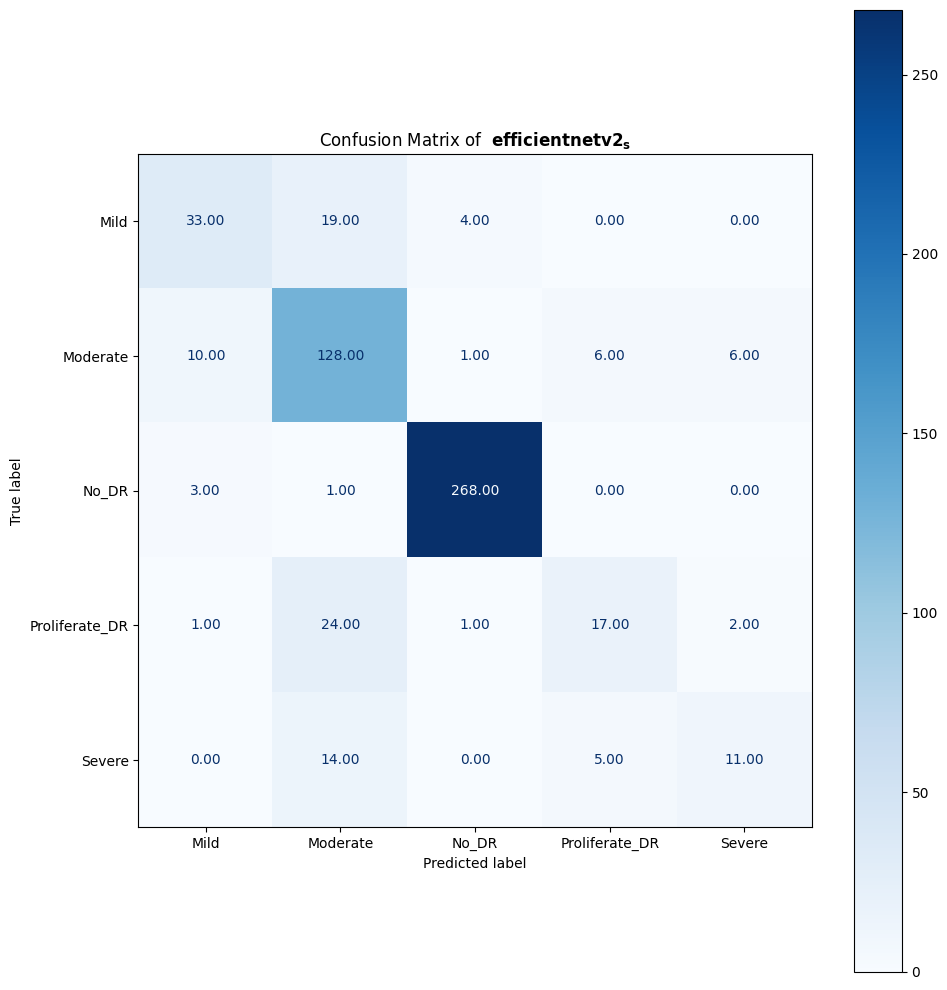

In [66]:
cm = confusion_matrix(y_true, y_pred, labels=None, normalize= None)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names if 'class_names' in locals() else None)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap='Blues', ax=ax, colorbar=True, values_format='.2f')
ax.set_title('Confusion Matrix of  ' +(rf'$\bf{{{model_name}}}$') )
plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


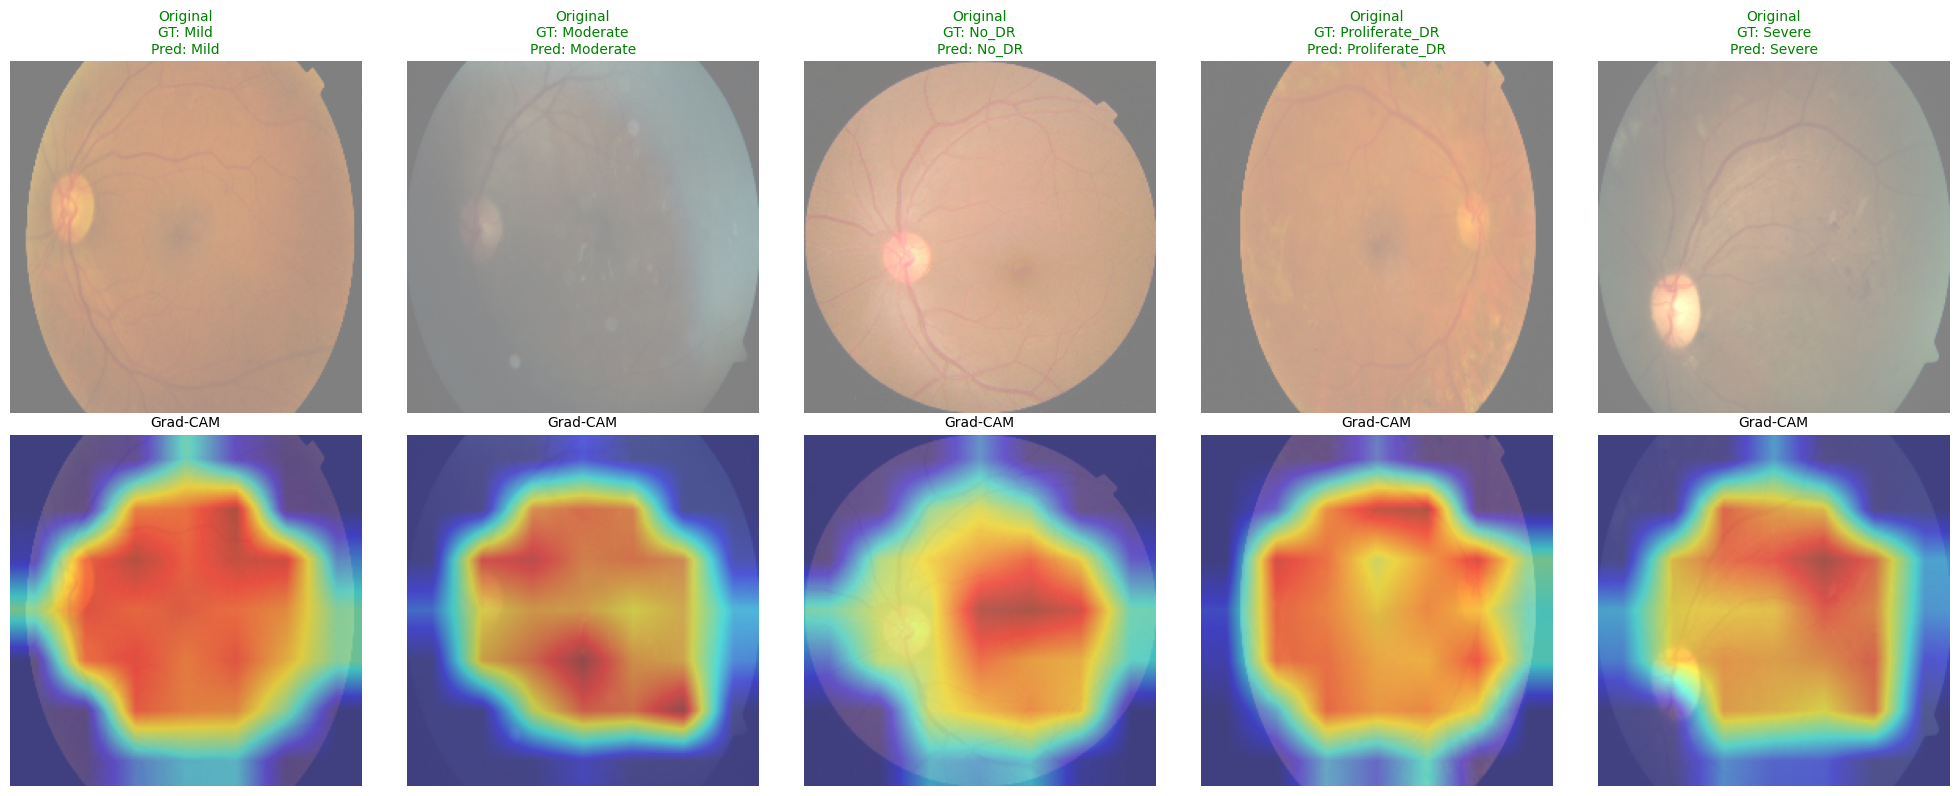

In [67]:
# Generate Grad-CAM heatmap for a specific class prediction
def generate_gradcam(model, input_tensor, target_class=None):
    # Lists to store intermediate feature maps and gradients
    features = []
    gradients = []

    # Hook function to capture feature map output
    def forward_hook(module, input, output):
        features.append(output)

    # Hook function to capture gradients during backward pass
    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    # Register hooks on the last convolutional layer
    target_layer = model.features[-2][-1].block[1]  # Typically the last residual block
    handle_forward = target_layer.register_forward_hook(forward_hook)
    handle_backward = target_layer.register_backward_hook(backward_hook)

    # Forward pass
    model.zero_grad()  # Zero out previous gradients
    output = model(input_tensor.unsqueeze(0))  # Add batch dimension

    # If no target class is specified, use the predicted class
    if target_class is None:
        target_class = output.argmax().item()

    # Backward pass for the target class
    loss = output[0, target_class]
    loss.backward()

    # Get gradients and features
    grads = gradients[0]  # Gradients: [B, C, H, W]
    fmap = features[0]    # Feature map: [B, C, H, W]

    # Compute weights via global average pooling on gradients
    weights = grads.mean(dim=(2, 3), keepdim=True)

    # Weighted sum of feature maps
    cam = (weights * fmap).sum(dim=1).squeeze()

    # Apply ReLU and normalize the heatmap
    cam = torch.relu(cam)
    cam = cam - cam.min()
    cam = cam / cam.max()

    # Convert to numpy array
    cam = cam.cpu().detach().numpy()

    # Remove hooks after use
    handle_forward.remove()
    handle_backward.remove()

    return cam

# Visualize predictions with and without Grad-CAM
def show_predictions_with_and_without_gradcam(model, loader, device, class_names):
    model.eval()  # Set model to evaluation mode

    # Dictionary to store one example per class
    collected = {classname: None for classname in class_names}

    # Loop to collect one correctly or incorrectly predicted image per class
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                true_label_idx = labels[i].cpu().item()
                true_label_name = class_names[true_label_idx]

                # Store the first example found for each class
                if collected[true_label_name] is None:
                    collected[true_label_name] = (inputs[i].cpu(), preds[i].cpu())

            # Stop once we have one image per class
            if all(v is not None for v in collected.values()):
                break

    # Create a figure with space for original and Grad-CAM images
    num_classes = len(class_names)
    fig = plt.figure(figsize=(num_classes * 4, 8))

    for idx, classname in enumerate(class_names):
        img, pred = collected[classname]
        cam = generate_gradcam(model, img.to(device), target_class=pred.item())  # Generate Grad-CAM

        # Prepare original image for display
        img_plot = img.permute(1, 2, 0).numpy()  # Change from CxHxW to HxWxC
        img_plot = (img_plot * 0.5) + 0.5  # Denormalize (from mean=0.5, std=0.5)
        img_plot = np.clip(img_plot, 0, 1)  # Clip values between 0 and 1

        # Resize and colorize CAM heatmap
        cam = cv2.resize(cam, (img_plot.shape[1], img_plot.shape[0]))
        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255  # Normalize to 0-1

        # Blend heatmap with original image
        superimposed_img = 0.5 * heatmap[..., ::-1] + 0.5 * img_plot  # Convert BGR to RGB

        # Plot original image
        ax = plt.subplot(2, num_classes, idx + 1)
        plt.imshow(img_plot)
        pred_label = class_names[pred.item()]
        color = 'green' if pred_label == classname else 'red'  # Green if correct, red if wrong
        ax.set_title(f"Original\nGT: {classname}\nPred: {pred_label}", color=color, fontsize=10)
        ax.axis('off')

        # Plot Grad-CAM heatmap
        ax = plt.subplot(2, num_classes, num_classes + idx + 1)
        plt.imshow(superimposed_img)
        ax.set_title("EfficientNet2_Grad-CAM", fontsize=10)
        ax.axis('off')

    plt.tight_layout()  # Optimize layout
    plt.show()  # Display all images

# Example usage of the visualization function
show_predictions_with_and_without_gradcam(model, test_loader, device, class_names)

In [68]:
# -----------------------
# Model : MobileNetV4
# -----------------------
model_name = "mobilenetv4"                # Model architecture name
model = timm.create_model("mobilenetv4_hybrid_large.e600_r384_in1k", pretrained=True)
model = model.to(device)                  # Move the model to the computation device (GPU if available, else CPU)


# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=2e-5)

In [71]:
# -----------------------------------------------------
# Step 11: Train the model
# ------------------------------------------------------

EPOCHS = 5  # Number of training epochs (can be increased)

for epoch in range(EPOCHS):
    print(f"\n--- Epoch {epoch+1}/{EPOCHS} ---")                                            # Epoch header
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)         # Train for one epoch
    val_loss, val_accuracy,y_true, y_pred = evaluate(model, val_loader, criterion, device)  # Validate

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.2f}%")



--- Epoch 1/5 ---


Training: 100%|██████████| 81/81 [00:11<00:00,  7.06it/s, loss=0.175]


Train Loss: 0.1746 | Val Loss: 0.9131 | Val Accuracy: 82.60%

--- Epoch 2/5 ---


Training: 100%|██████████| 81/81 [00:11<00:00,  7.10it/s, loss=0.165]


Train Loss: 0.1648 | Val Loss: 0.6479 | Val Accuracy: 82.78%

--- Epoch 3/5 ---


Training: 100%|██████████| 81/81 [00:11<00:00,  7.10it/s, loss=0.266]


Train Loss: 0.2657 | Val Loss: 0.7122 | Val Accuracy: 82.97%

--- Epoch 4/5 ---


Training: 100%|██████████| 81/81 [00:11<00:00,  6.92it/s, loss=0.238]


Train Loss: 0.2378 | Val Loss: 0.7390 | Val Accuracy: 82.60%

--- Epoch 5/5 ---


Training: 100%|██████████| 81/81 [00:11<00:00,  7.16it/s, loss=0.149]


Train Loss: 0.1486 | Val Loss: 0.7097 | Val Accuracy: 83.52%


In [73]:
# -----------------------
# Step 12: Test evaluation
# -----------------------

#y_true = torch.tensor(y_true)
#y_pred = torch.tensor(y_pred)
test_loss, test_accuracy,y_true, y_pred = evaluate(model, test_loader, criterion, device)
print(f"\nTest Accuracy: {test_accuracy:.2f}\n")  # Display test accuracy

# --- Classification Report ---
print(f'Classification Report of \033[1m{model_name}\033[0m \n')
print(classification_report(y_true, y_pred, target_names=class_names))

# --- Metrics: Precision, Recall, F1, AUC ---
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print Metrics
print(f"\nPrecision (weighted): {precision:.4f}")
print(f"\nRecall (weighted): {recall:.4f}")
print(f"\nf1_score (weighted): {f1:.4f}\n")



Test Accuracy: 79.96

Classification Report of mobilenetv4 

                precision    recall  f1-score   support

          Mild       0.63      0.43      0.51        56
      Moderate       0.66      0.81      0.73       151
         No_DR       0.97      0.99      0.98       272
Proliferate_DR       0.50      0.40      0.44        45
        Severe       0.50      0.33      0.40        30

      accuracy                           0.80       554
     macro avg       0.65      0.59      0.61       554
  weighted avg       0.79      0.80      0.79       554



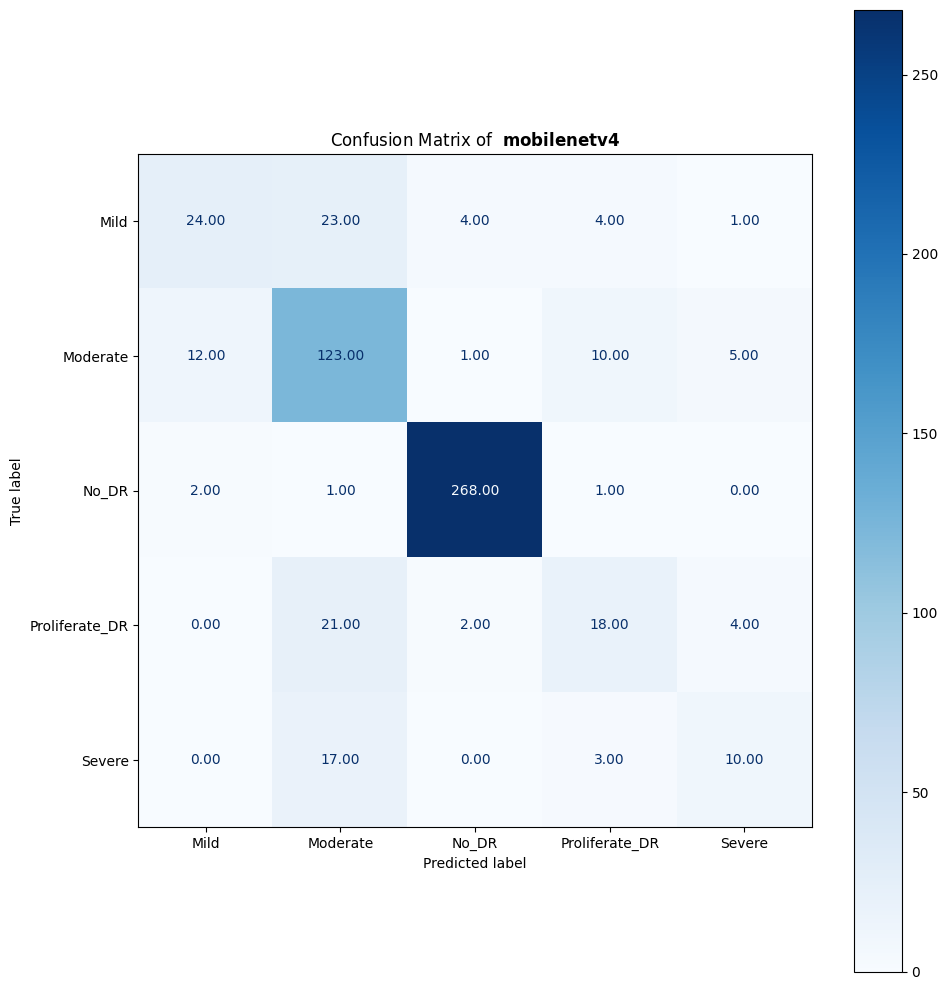

In [74]:
cm = confusion_matrix(y_true, y_pred, labels=None, normalize= None)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names if 'class_names' in locals() else None)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap='Blues', ax=ax, colorbar=True, values_format='.2f')
ax.set_title('Confusion Matrix of  ' +(rf'$\bf{{{model_name}}}$') )
plt.tight_layout()
plt.show()

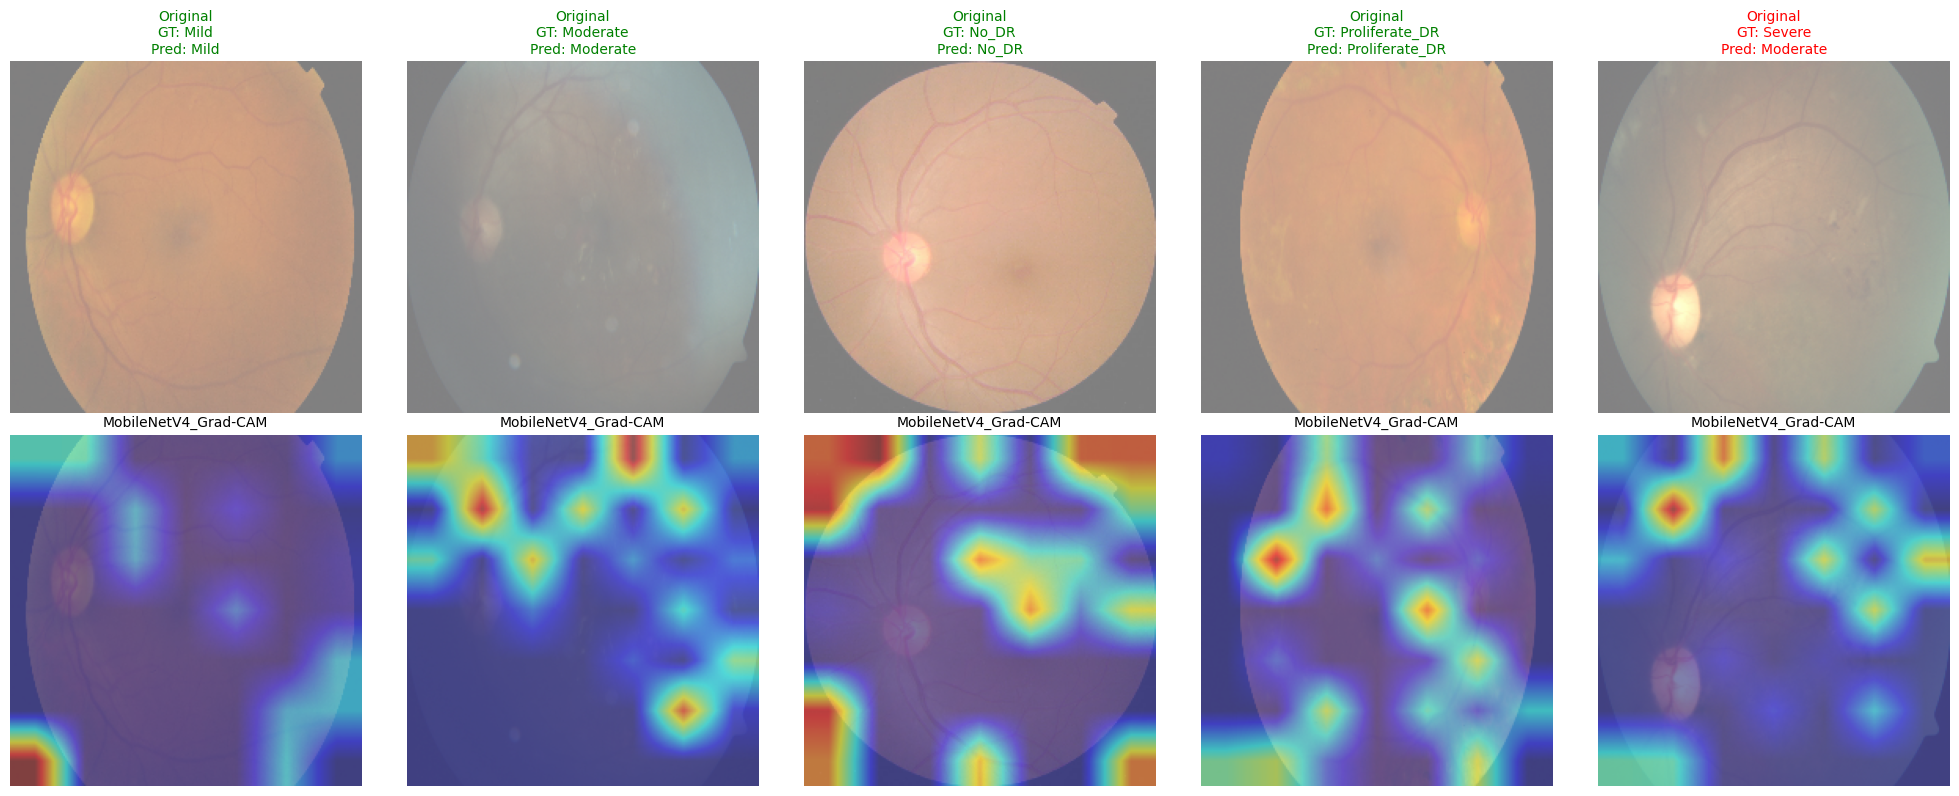

In [93]:
# Generate Grad-CAM heatmap for a specific class prediction
def generate_gradcam(model, input_tensor, target_class=None):
    # Lists to store intermediate feature maps and gradients
    features = []
    gradients = []

    # Hook function to capture feature map output
    def forward_hook(module, input, output):
        features.append(output)

    # Hook function to capture gradients during backward pass
    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    # Register hooks on the last convolutional layer
    target_layer = None

    if target_layer is None:
            last_conv = None
            for name, m in model.named_modules():
                    if 'conv_head' in name:
                          break
                    if isinstance(m, torch.nn.Conv2d):
                          last_conv = m
            target_layer = last_conv
    assert target_layer is not None, "Couldn't locate a suitable conv/UIB layer."
    #target_layer = model.stages[-1][-2]  # Typically the last residual block
    handle_forward = target_layer.register_forward_hook(forward_hook)
    handle_backward = target_layer.register_backward_hook(backward_hook)

    # Forward pass
    model.zero_grad()  # Zero out previous gradients
    output = model(input_tensor.unsqueeze(0))  # Add batch dimension

    # If no target class is specified, use the predicted class
    if target_class is None:
        target_class = output.argmax().item()

    # Backward pass for the target class
    loss = output[0, target_class]
    loss.backward()

    # Get gradients and features
    grads = gradients[0]  # Gradients: [B, C, H, W]
    fmap = features[0]    # Feature map: [B, C, H, W]

    # Compute weights via global average pooling on gradients
    weights = grads.mean(dim=(2, 3), keepdim=True)

    # Weighted sum of feature maps
    cam = (weights * fmap).sum(dim=1).squeeze()

    # Apply ReLU and normalize the heatmap
    cam = torch.relu(cam)
    cam = cam - cam.min()
    cam = cam / cam.max()

    # Convert to numpy array
    cam = cam.cpu().detach().numpy()

    # Remove hooks after use
    handle_forward.remove()
    handle_backward.remove()

    return cam

# Visualize predictions with and without Grad-CAM
def show_predictions_with_and_without_gradcam(model, loader, device, class_names):
    model.eval()  # Set model to evaluation mode

    # Dictionary to store one example per class
    collected = {classname: None for classname in class_names}

    # Loop to collect one correctly or incorrectly predicted image per class
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                true_label_idx = labels[i].cpu().item()
                true_label_name = class_names[true_label_idx]

                # Store the first example found for each class
                if collected[true_label_name] is None:
                    collected[true_label_name] = (inputs[i].cpu(), preds[i].cpu())

            # Stop once we have one image per class
            if all(v is not None for v in collected.values()):
                break

    # Create a figure with space for original and Grad-CAM images
    num_classes = len(class_names)
    fig = plt.figure(figsize=(num_classes * 4, 8))

    for idx, classname in enumerate(class_names):
        img, pred = collected[classname]
        cam = generate_gradcam(model, img.to(device), target_class=pred.item())  # Generate Grad-CAM

        # Prepare original image for display
        img_plot = img.permute(1, 2, 0).numpy()  # Change from CxHxW to HxWxC
        img_plot = (img_plot * 0.5) + 0.5  # Denormalize (from mean=0.5, std=0.5)
        img_plot = np.clip(img_plot, 0, 1)  # Clip values between 0 and 1

        # Resize and colorize CAM heatmap
        cam = cv2.resize(cam, (img_plot.shape[1], img_plot.shape[0]))
        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255  # Normalize to 0-1

        # Blend heatmap with original image
        superimposed_img = 0.5 * heatmap[..., ::-1] + 0.5 * img_plot  # Convert BGR to RGB

        # Plot original image
        ax = plt.subplot(2, num_classes, idx + 1)
        plt.imshow(img_plot)
        pred_label = class_names[pred.item()]
        color = 'green' if pred_label == classname else 'red'  # Green if correct, red if wrong
        ax.set_title(f"Original\nGT: {classname}\nPred: {pred_label}", color=color, fontsize=10)
        ax.axis('off')

        # Plot Grad-CAM heatmap
        ax = plt.subplot(2, num_classes, num_classes + idx + 1)
        plt.imshow(superimposed_img)
        ax.set_title("MobileNetV4_Grad-CAM", fontsize=10)
        ax.axis('off')

    plt.tight_layout()  # Optimize layout
    plt.show()  # Display all images

# Example usage of the visualization function
show_predictions_with_and_without_gradcam(model, test_loader, device, class_names)

In [97]:
# -----------------------
# Model: VIT
# -----------------------
model_name ="VIT"                      # Model architecture name
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=num_classes)
model = model.to(device)               # Move the model to the computation device (GPU if available, else CPU)

# Define optimizer
optimizer = optim.AdamW(model.parameters(), lr=2e-5)               

In [98]:
# -----------------------------------------------------
# Step 11: Train the model
# ------------------------------------------------------

EPOCHS = 5  # Number of training epochs (can be increased)

for epoch in range(EPOCHS):
    print(f"\n--- Epoch {epoch+1}/{EPOCHS} ---")  # Epoch header
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)  # Train for one epoch
    val_loss, val_accuracy,y_true, y_pred = evaluate(model, val_loader, criterion, device)  # Validate

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.2f}%")


--- Epoch 1/5 ---


Training: 100%|██████████| 81/81 [00:22<00:00,  3.64it/s, loss=0.709]


Train Loss: 0.7090 | Val Loss: 0.5529 | Val Accuracy: 79.67%

--- Epoch 2/5 ---


Training: 100%|██████████| 81/81 [00:22<00:00,  3.65it/s, loss=0.451]


Train Loss: 0.4511 | Val Loss: 0.5473 | Val Accuracy: 79.30%

--- Epoch 3/5 ---


Training: 100%|██████████| 81/81 [00:22<00:00,  3.64it/s, loss=0.331]


Train Loss: 0.3311 | Val Loss: 0.7350 | Val Accuracy: 71.79%

--- Epoch 4/5 ---


Training: 100%|██████████| 81/81 [00:22<00:00,  3.64it/s, loss=0.315]


Train Loss: 0.3146 | Val Loss: 0.5742 | Val Accuracy: 80.95%

--- Epoch 5/5 ---


Training: 100%|██████████| 81/81 [00:22<00:00,  3.64it/s, loss=0.19]


Train Loss: 0.1898 | Val Loss: 0.5776 | Val Accuracy: 82.78%


In [99]:
# -----------------------
# Step 12: Test evaluation
# -----------------------

#y_true = torch.tensor(y_true)
#y_pred = torch.tensor(y_pred)
test_loss, test_accuracy,y_true, y_pred = evaluate(model, test_loader, criterion, device)
print(f"\nTest Accuracy: {test_accuracy:.2f}\n")  # Display test accuracy

# --- Classification Report ---
print(f'Classification Report of \033[1m{model_name}\033[0m \n')
print(classification_report(y_true, y_pred, target_names=class_names))

# --- Metrics: Precision, Recall, F1, AUC ---
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"\nPrecision (weighted): {precision:.4f}")
print(f"\nRecall (weighted): {recall:.4f}")
print(f"\nf1_score (weighted): {f1:.4f}\n")


Test Accuracy: 81.05

Classification Report of VIT 

                precision    recall  f1-score   support

          Mild       0.54      0.66      0.60        56
      Moderate       0.70      0.79      0.74       151
         No_DR       0.97      0.98      0.98       272
Proliferate_DR       0.70      0.47      0.56        45
        Severe       0.42      0.17      0.24        30

      accuracy                           0.81       554
     macro avg       0.67      0.61      0.62       554
  weighted avg       0.80      0.81      0.80       554



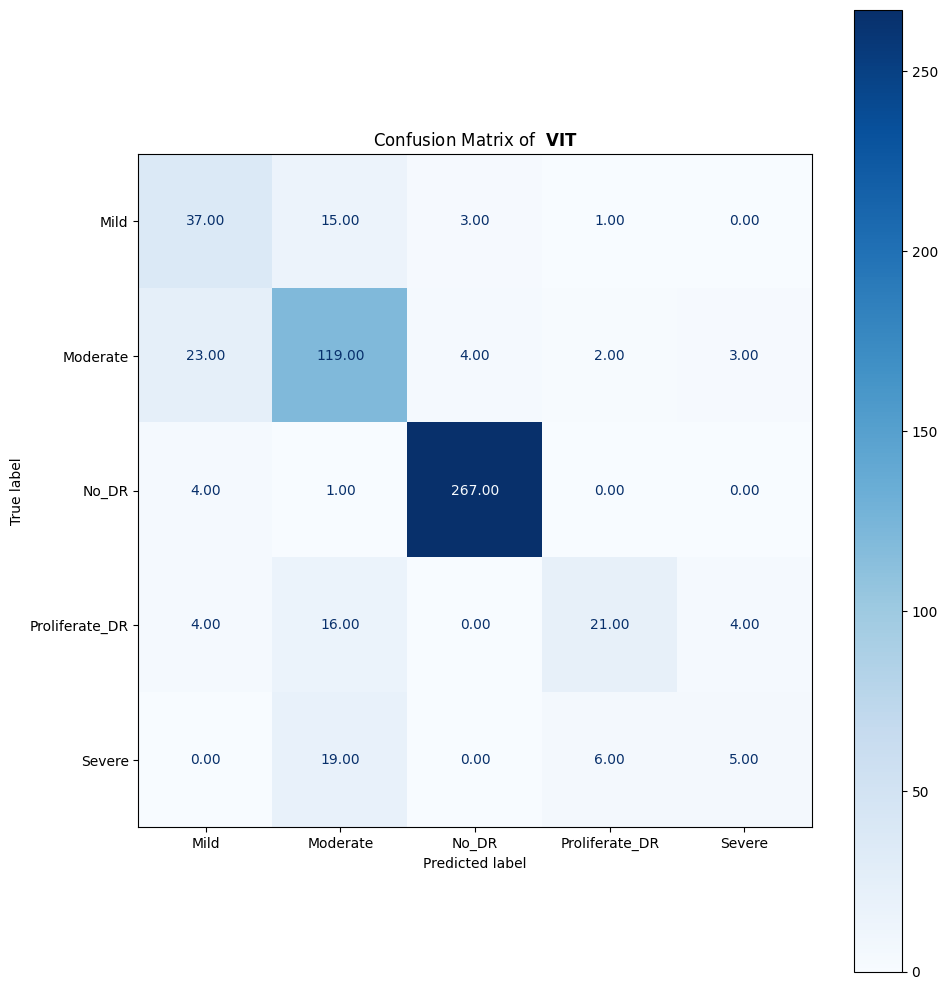

In [100]:
cm = confusion_matrix(y_true, y_pred, labels=None, normalize= None)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names if 'class_names' in locals() else None)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap='Blues', ax=ax, colorbar=True, values_format='.2f')
ax.set_title('Confusion Matrix of  ' +(rf'$\bf{{{model_name}}}$') )
plt.tight_layout()
plt.show()

In [11]:
# -----------------------
# Model: DeiT |||
# ----------------------
model_name ="DeiT 3"              # Model architecture name
model = timm.create_model('deit3_base_patch16_224', pretrained=True, num_classes=num_classes)
model = model.to(device)         # Move the model to the computation device (GPU if available, else CPU)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=2e-5)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [12]:
# -----------------------------------------------------
# Step 11: Train the model
# ------------------------------------------------------

EPOCHS = 5  # Number of training epochs (can be increased)

for epoch in range(EPOCHS):
    print(f"\n--- Epoch {epoch+1}/{EPOCHS} ---")  # Epoch header
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)  # Train for one epoch
    val_loss, val_accuracy,y_true, y_pred = evaluate(model, val_loader, criterion, device)  # Validate

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.2f}%")


--- Epoch 1/5 ---


Training: 100%|██████████| 81/81 [00:23<00:00,  3.38it/s, loss=0.68]


Train Loss: 0.6799 | Val Loss: 0.5232 | Val Accuracy: 80.77%

--- Epoch 2/5 ---


Training: 100%|██████████| 81/81 [00:22<00:00,  3.60it/s, loss=0.424]


Train Loss: 0.4238 | Val Loss: 0.4361 | Val Accuracy: 84.62%

--- Epoch 3/5 ---


Training: 100%|██████████| 81/81 [00:22<00:00,  3.59it/s, loss=0.257]


Train Loss: 0.2574 | Val Loss: 0.4337 | Val Accuracy: 84.25%

--- Epoch 4/5 ---


Training: 100%|██████████| 81/81 [00:22<00:00,  3.60it/s, loss=0.128]


Train Loss: 0.1276 | Val Loss: 0.4961 | Val Accuracy: 84.25%

--- Epoch 5/5 ---


Training: 100%|██████████| 81/81 [00:22<00:00,  3.59it/s, loss=0.0631]


Train Loss: 0.0631 | Val Loss: 0.6591 | Val Accuracy: 82.42%


In [16]:
# -----------------------
# Step 12: Test evaluation
# -----------------------

#y_true = torch.tensor(y_true)
#y_pred = torch.tensor(y_pred)
test_loss, test_accuracy,y_true, y_pred = evaluate(model, test_loader, criterion, device)
print(f"\nTest Accuracy: {test_accuracy:.2f}\n")  # Display test accuracy

# --- Classification Report ---
print(f'Classification Report of \033[1m{model_name}\033[0m \n')
print(classification_report(y_true, y_pred, target_names=class_names))

# --- Metrics: Precision, Recall, F1, AUC ---
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"\nPrecision (weighted): {precision:.4f}")
print(f"\nRecall (weighted): {recall:.4f}")
print(f"\nf1_score (weighted): {f1:.4f}\n")


Test Accuracy: 83.21

Classification Report of DeiT 3 

                precision    recall  f1-score   support

          Mild       0.61      0.62      0.62        56
      Moderate       0.72      0.84      0.77       151
         No_DR       0.99      0.98      0.98       272
Proliferate_DR       0.79      0.49      0.60        45
        Severe       0.50      0.37      0.42        30

      accuracy                           0.83       554
     macro avg       0.72      0.66      0.68       554
  weighted avg       0.83      0.83      0.83       554


Precision (weighted): 0.8322

Recall (weighted): 0.8321

f1_score (weighted): 0.8275



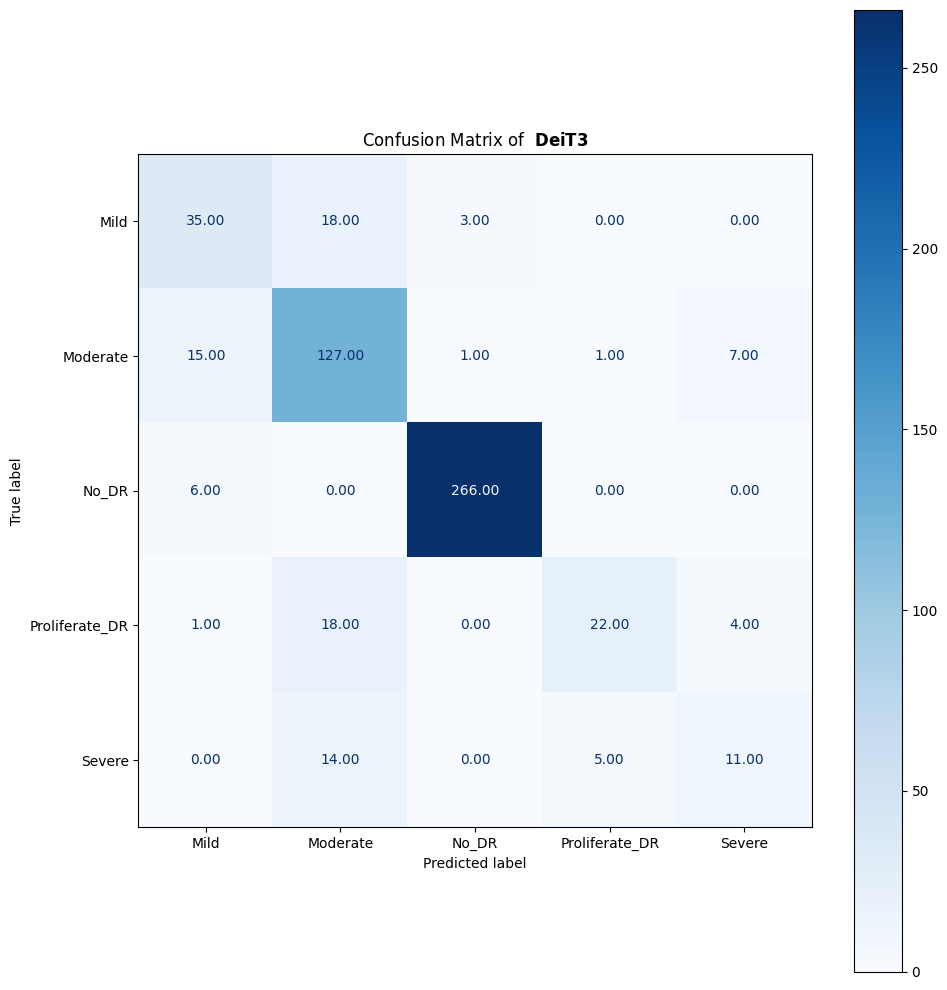

In [14]:
cm = confusion_matrix(y_true, y_pred, labels=None, normalize= None)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names if 'class_names' in locals() else None)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap='Blues', ax=ax, colorbar=True, values_format='.2f')
ax.set_title('Confusion Matrix of  ' +(rf'$\bf{{{model_name}}}$') )
plt.tight_layout()
plt.show()

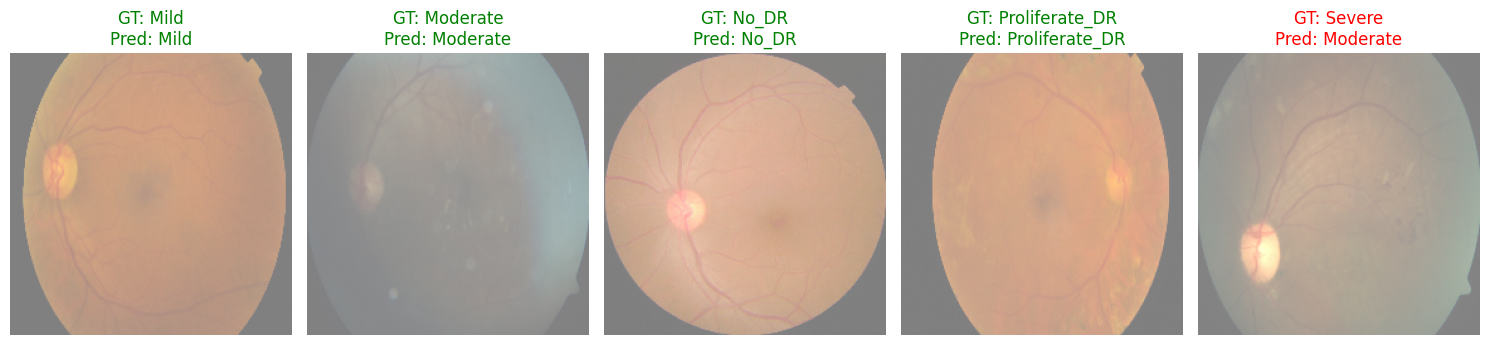

In [15]:
# Function to visualize one prediction per class
def show_predictions_per_class(model, loader, device, class_names):
    model.eval()  # Set model to evaluation mode (disables dropout, etc.)

    # Initialize dictionary to store one image per class
    collected = {classname: None for classname in class_names}

    with torch.no_grad():  # No gradient calculation needed for evaluation
        for inputs, labels in loader:
            inputs = inputs.to(device)  # Move images to device (GPU/CPU)
            labels = labels.to(device)
            outputs = model(inputs)  # Forward pass
            _, preds = torch.max(outputs, 1)  # Get predicted class indices

            for i in range(inputs.size(0)):
                true_label_idx = labels[i].cpu().item()  # Ground truth class index
                true_label_name = class_names[true_label_idx]  # Get class name

                # If we haven't collected a sample for this class yet, store it
                if collected[true_label_name] is None:
                    collected[true_label_name] = (inputs[i].cpu(), preds[i].cpu())

            # If we've collected one sample for every class, we can stop
            if all(v is not None for v in collected.values()):
                break

    # Now plot the collected images and their predictions
    num_classes = len(class_names)
    fig = plt.figure(figsize=(15, 4))  # Set figure size

    for idx, classname in enumerate(class_names):
        img, pred = collected[classname]  # Retrieve stored image and prediction

        ax = plt.subplot(1, num_classes, idx + 1)  # Create subplot for each class
        img_plot = img.permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C)
        img_plot = (img_plot * 0.5) + 0.5  # Undo normalization (from [-1, 1] to [0, 1])
        img_plot = np.clip(img_plot, 0, 1)  # Clip values to valid range

        plt.imshow(img_plot)  # Display image
        pred_label = class_names[pred.item()]  # Predicted label name
        color = 'green' if pred_label == classname else 'red'  # Green if correct, red if wrong

        ax.set_title(f"GT: {classname}\nPred: {pred_label}", color=color)  # Set title with color
        ax.axis('off')  # Hide axes

    plt.tight_layout()  # Adjust spacing
    plt.show()  # Display the plot

# Call the function to show predictions
show_predictions_per_class(model, test_loader, device, class_names)
